# Building Agentic Applications

In [1]:
# Demo

## What is LLM?

In [2]:
#! pip install langchain langchain-community langchain-core langchain-openai

In [1]:

from langchain_openai import ChatOpenAI
import openai
from langchain_community.callbacks import get_openai_callback

In [2]:
llm_model = ChatOpenAI(temperature=0.0, 
                        model="gpt-4-turbo",
                       openai_api_key="XXXX")

In [3]:
prompt = "Who is the first person to step on moon?"

In [4]:
with get_openai_callback() as cb:
    response = llm_model.invoke(prompt)

In [5]:
response

AIMessage(content='The first person to step on the Moon was Neil Armstrong. He did so on July 20, 1969, as part of the Apollo 11 mission, famously stating, "That\'s one small step for [a] man, one giant leap for mankind."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 17, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_101a39fff3', 'id': 'chatcmpl-BG8J9ZAkpygpQqwrhWbQZBi9whVhH', 'finish_reason': 'stop', 'logprobs': None}, id='run-dc5d6e18-89ab-4a93-ac39-60f055573915-0', usage_metadata={'input_tokens': 17, 'output_tokens': 55, 'total_tokens': 72, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
response.content

'The first person to step on the Moon was Neil Armstrong. He did so on July 20, 1969, as part of the Apollo 11 mission, famously stating, "That\'s one small step for [a] man, one giant leap for mankind."'

In [7]:
cb

Tokens Used: 72
	Prompt Tokens: 17
	Completion Tokens: 55
Successful Requests: 1
Total Cost (USD): $0.00182

## Types of LLM

- Types of models

- Open source vs Closed source models

## AI Agents 

- What are Agents?

- Why they are gaining much attention over LLMs?

In [8]:
# Any questions so far? Let's move on to the practical session.

### Building the First AI Agent: A Beginner's Guide

In [9]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph==0.3.21
#%pip install git+https://github.com/langchain-ai/langgraph.git


In [10]:
#1. Core components of an AI Agent

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
import random


In [12]:
class State(TypedDict):
    graph_state: str

In [13]:
def node1(state):
    print(f"-----Node1----")
    return {"graph_state":state["graph_state"]+ "I am "}

def node2(state):
    print(f"-----Node2----")
    return {"graph_state":state["graph_state"]+ "Happy "}

def node3(state):
    print(f"-----Node3----")
    return {"graph_state":state["graph_state"]+ "Sad "}

In [14]:
from typing import Literal

def deci_take(state)->Literal["node2", "node3"]:
    
    number = random.randint(1, 100)
    #print(f"Number is {number}")
    
    return "node2" if number % 2 == 0 else "node3"

In [15]:
builder = StateGraph(State)

builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

In [16]:
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", deci_take)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

In [17]:
graph = builder.compile()

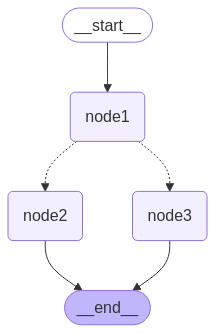

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

-----Node1----
-----Node3----


{'graph_state': 'Hi, this is Lance.I am Sad '}

In [20]:
# 2. Building tools and binding with LLM

In [21]:
llm_model

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x1122d0f10>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x112176290>, root_client=<openai.OpenAI object at 0x111678850>, root_async_client=<openai.AsyncOpenAI object at 0x1122d3790>, model_name='gpt-4-turbo', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [22]:
res = llm_model.invoke("What are AI Agents")

In [40]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END




# @tool
# def multiply(a: int, b: int) -> int:
#     """Multiply two numbers."""
#     return a * b


# llm_with_tools = llm_model.bind_tools([multiply])

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def add(a: int, b: int) -> int:
    """add two numbers."""
    return a + b

tools_map = {
    "multiply": multiply,
    "add": add
}



In [43]:

llm_with_tools = llm_model.bind_tools(list(tools_map.values()))

In [44]:


def llm_node(state: dict) -> dict:
    messages = state.get("messages", [])
    response = llm_with_tools.invoke(messages)
    updated_state = {"messages": messages + [response]}

    if response.tool_calls:
        for tool_call in response.tool_calls:
            name = tool_call["name"]
            args = tool_call["args"]
            tool = tools_map.get(name)
            if tool:
                result = tool.invoke(args)
                updated_state["messages"].append(AIMessage(content=str(result)))
                updated_state["result"] = result
            else:
                updated_state["messages"].append(AIMessage(content=f"Unknown tool: {name}"))

    return updated_state


In [45]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(dict)
builder.set_entry_point("llm_node")
builder.add_node("llm_node", llm_node)
builder.add_edge("llm_node", END)

graph = builder.compile()

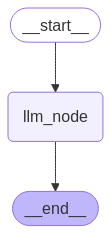

In [46]:
graph

In [49]:
input_state = {
    "messages": [HumanMessage(content="What is 5 times 9?")]
}

result = graph.invoke(input_state)


In [50]:
for msg in result["messages"]:
    print(msg.content)

How are you?
I'm just a computer program, so I don't have feelings, but thanks for asking! How can I assist you today?


In [12]:
# Any questions

## Real world usecase- Content Generation

In [9]:
# Explain the flow and give code walk through

In [32]:
# final demo and explain them 

In [33]:
# Show about the github code repositiry

## Assignment

In [15]:
# Explain them workflow vs Agentic applications

In [16]:
# Give the assignment of agentic work

In [17]:
# Show the LinkedIn and github profile

In [18]:
# questioners

In [19]:
# END